In [114]:
import cv2
import matplotlib.pyplot as plt
import os
import torch
from pathlib import Path

# Parameters

In [115]:
MAX_IMAGES = 13233 #MAX_VALUE:13233
IMAGE_SIZE = 128 #Order of matrix
N_EIGEN = 400 #Number of eigenvectors to calculate. MAX_VALUE:IMAGE_SIZE^2
THRESHOLD_DISTANCE = 1000

# Training

In [116]:
flattened_images = []
dataset_path = Path("./faces")
for file in os.listdir(dataset_path):
    
    if len(flattened_images) == MAX_IMAGES:
        break

    img_path = dataset_path / file
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    flatenned_img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)).flatten()
    
    if flatenned_img is not None:
        flattened_images.append(flatenned_img)

In [117]:
faces_mat = torch.tensor(flattened_images, dtype=torch.float32)
faces_mat.shape

torch.Size([13233, 16384])

In [118]:
mean_face = torch.mean(faces_mat, dim=0)
mean_face.shape

torch.Size([16384])

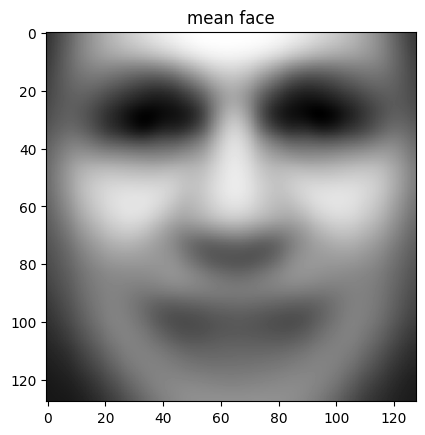

In [119]:
plt.imshow(mean_face.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")
plt.title("mean face")
plt.show()

In [120]:
normalized_faces = faces_mat - mean_face
normalized_faces.shape

torch.Size([13233, 16384])

In [121]:
eigenvectors, eigenvalues, _ = torch.pca_lowrank(normalized_faces.T, q=N_EIGEN)
eigenvectors.shape

torch.Size([16384, 400])

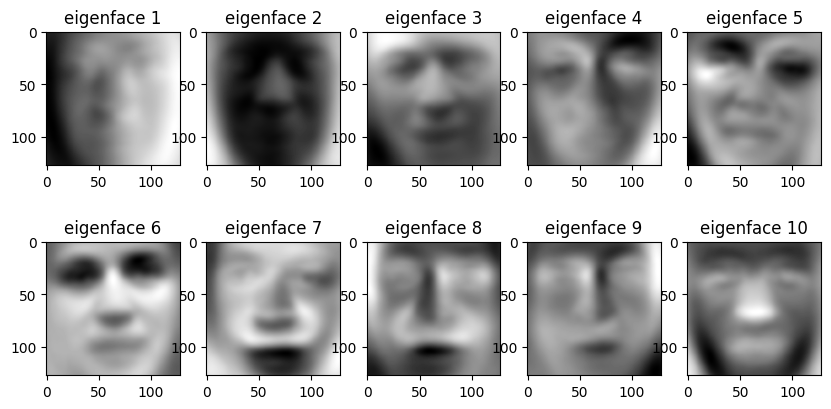

In [122]:
display_eigenfaces = eigenvectors.T[:10]

plt.figure(figsize= (10, 5))
for i in range(10):
    eigenface = display_eigenfaces[i].reshape(IMAGE_SIZE, IMAGE_SIZE)
    plt.subplot(2, 5, i + 1)
    plt.imshow(eigenface, cmap="gray")
    plt.title(f"eigenface {i + 1}")


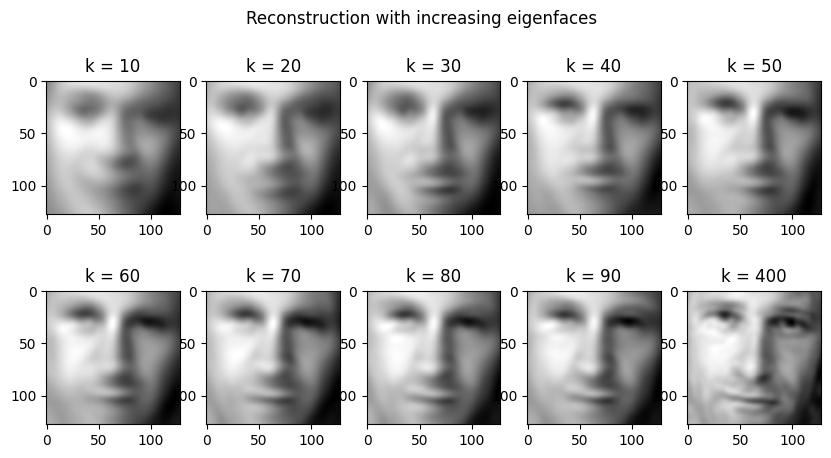

In [123]:
plt.figure(figsize= (10, 5))
for k, i in zip([9, 19, 29, 39, 49, 59, 69, 79, 89, N_EIGEN-1], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    eigenvectors_k = eigenvectors[:, :k+1]
    weight = normalized_faces[0, :].reshape(1, -1).mm(eigenvectors_k)
    projected_face = weight.mm(eigenvectors_k.T)
    reconstructed_face  = projected_face + mean_face
    plt.subplot(2, 5, i + 1)
    plt.imshow(reconstructed_face.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")
    plt.title(f"k = {k + 1}")
plt.suptitle("Reconstruction with increasing eigenfaces")
plt.show()

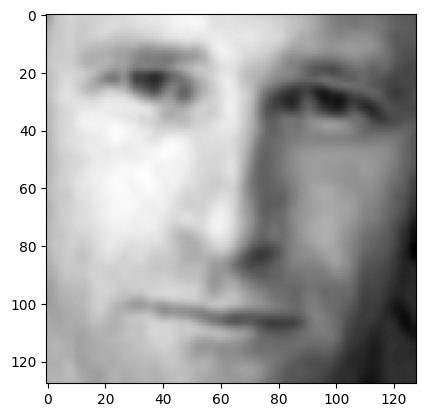

In [124]:
plt.imshow(faces_mat[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")


# Testing


In [125]:
img_index = int(input(f"Enter the index of the image you want to test with (0 - {MAX_IMAGES - 1}) > "))
img_path = Path(f"./faces/{os.listdir(Path('./faces'))[img_index]}")
img_path

WindowsPath('faces/Angelina_Jolie_0013.pgm')

In [126]:
input_img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
flatenned_input_img = torch.tensor(cv2.resize(input_img, (IMAGE_SIZE, IMAGE_SIZE)).flatten())
normalized_input_img = (flatenned_input_img - mean_face).reshape(1, -1)
normalized_input_img.shape

torch.Size([1, 16384])

In [127]:
input_weights = normalized_input_img.mm(eigenvectors)
input_weights.shape

torch.Size([1, 400])

In [128]:
distances = torch.norm(normalized_faces.mm(eigenvectors) - input_weights, dim=1)
distances

tensor([6771.4863, 6120.3047, 4560.7241,  ..., 5032.2603, 4235.8735,
        6431.6890])

In [129]:
min_index = torch.argmin(distances)
closest_match_path = f"{os.listdir(Path('./faces'))[min_index]}.jpg"
closest_match_path

'Angelina_Jolie_0013.pgm.jpg'

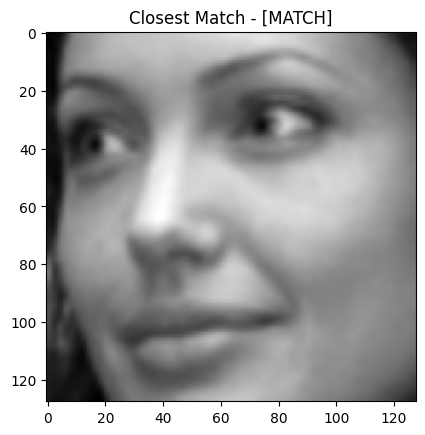

In [130]:
plt.imshow(faces_mat[min_index].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")
plt.title(f"Closest Match - [{'MATCH' if distances[min_index] < THRESHOLD_DISTANCE else 'NO MATCH'}]")
plt.show()